<a href="https://colab.research.google.com/github/desakim/ESAA_OB/blob/main/desakim_ob0915_session2_modeltraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **| 모델 훈련 연습 문제**
___
- 출처 : 핸즈온 머신러닝 Ch04 연습문제 1, 5, 9, 10
- 개념 문제의 경우 텍스트 셀을 추가하여 정답을 적어주세요.

### **1. 수백만 개의 특성을 가진 훈련 세트에서는 어떤 선형 회귀 알고리즘을 사용할 수 있을까요?**
___


답: 확률적 경사 하강법 또는 미니배치 경사 하강법. 훈련 세트가 메모리 크기에 맞으면 배치 경사 하강법도 가능함.

### **2. 배치 경사 하강법을 사용하고 에포크마다 검증 오차를 그래프로 나타내봤습니다. 검증 오차가 일정하게 상승되고 있다면 어떤 일이 일어나고 있는 걸까요? 이 문제를 어떻게 해결할 수 있나요?**
___

답: 학습률이 너무 높고 알고리즘이 발산하는 것일 수 있음. 훈련 에러도 올라간다면 이 문제가 확실, 학습률을 낮추어야 함.

그러나 훈련 에러가 올라가지 않는다면 모델이 과대적합되어 있는 것이므로 훈련을 멈추어야 함.

### **3. 릿지 회귀를 사용했을 때 훈련 오차가 검증 오차가 거의 비슷하고 둘 다 높았습니다. 이 모델에는 높은 편향이 문제인가요, 아니면 높은 분산이 문제인가요? 규제 하이퍼파라미터 $\alpha$를 증가시켜야 할까요 아니면 줄여야 할까요?**
___

답: 모델이 과소적합되었을 가능성이 높다. 높은 편향을 가진 모델이므로 규제 파라미터를 줄여야 한다.

### **4. 다음과 같이 사용해야 하는 이유는?**
___
- 평범한 선형 회귀(즉, 아무런 규제가 없는 모델) 대신 릿지 회귀
- 릿지 회귀 대신 라쏘 회귀
- 라쏘 회귀 대신 엘라스틱넷

답:
* 규제가 있는 모델이 규제가 없는 모델보다 일반적으로 성능이 좋다.
* 라쏘 회귀는 L1 페널티를 사용하므로, 가장 중요한 가중치를 제외하고 모두 0이 되는 모델을 만든다. 자동으로 특성 선택의 효과를 가지므로, 일부 특성만 실제로 유용할 것 같을 때 사용하면 좋다.
* 라쏘 회귀는 어떤 경우에 불규칙하게 행동하므로, 엘라스틱넷이 일반적으로 더 선호된다. 그러나 추가적인 하이퍼파라미터가 생긴다.

  불규칙한 행동이 없는 라쏘 회귀를 원한다면 엘라스틱넷에 ll_ratio를 1에 가깝게 설정하면 된다.

### **추가) 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현해보세요(사이킷런은 사용하지 마세요)**


---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()

In [3]:
X = iris["data"][:, (2, 3)]  #꽃잎 길이, 꽃잎 넓이
y = iris["target"]

In [4]:
X_with_bias = np.c_[np.ones([len(X), 1]), X] #모든 샘플에 편향 추가

In [5]:
np.random.seed(2042)

In [6]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

In [7]:
rnd_indices = np.random.permutation(total_size) #무작위로 나열한 array 반환

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]

X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]

X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

* 타깃은 클래스 인덱스(0,1,2)이지만, 소프트맥스 회귀 모델을 훈련시키는 데 필요한 것은 타깃 클래스의 확률임.
* 각 샘플에서 확률이 1인 타깃 클래스를 제외한 다른 클래스의 확률은 0.
* 다른 말로, 주어진 샘플에 대한 클래스 확률이 원-핫 벡터임

* 클래스는 0,1,2이므로 max는 2, 클래스의 개수는 3개이므로 +1
* Y_one_hot은 len_y의 길이만큼의 행, 3개의 열 구조로 생성되고 모두 0으로 채워짐
* np.arange(m), y는 행 열을 선택하게 됨.
* 행과 열이 모두 0부터 시작하며, iris_target값이 y이므로 y=0인 경우 첫번째에 1, y=1인 경우 2번째에 1, y=3인 경우 3번째 열에 1
* 즉 Y_one_hot은 빈 틀 / []로 행,열을 지정

In [8]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [9]:
#to_one_hot() 함수 테스트
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [10]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [11]:
#훈련 세트와 테스트 세트의 타깃 클래스 확률을 담은 행렬 만들기
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

##소프트맥스 함수

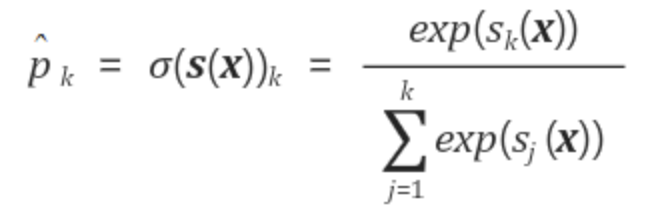

* s(x): 샘플 x에 대한 각 클래스의 점수를 담고 있는 벡터
* k: 클래스 수
* sigma(s(x))k: 샘플 x에 대한 각 클래스의 점수가 주어졌을 때 이 샘플이 클래스 k에 속할 추정 확률

In [12]:
#소프트맥스 함수 만들기
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [13]:
#입력과 출력 개수 정의
n_inputs = X_train.shape[1] # == 3 (특성 2개와 편향)
n_outputs = len(np.unique(y_train))   # == 3 (3개의 붓꽃 클래스)

## 크로스 엔트로피 비용 함수
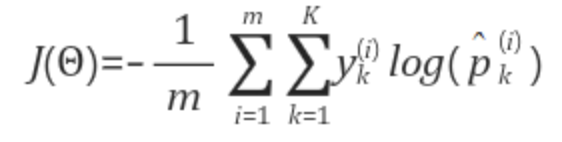

* j번째 샘플에 대한 타깃 클래스가 k일 때, yk(i)가 1이고 그 외에는 0
* K=2일 때, 이 비용 함수는 로지스틱 회귀 비용 함수와 같음

## 클래스 K에 대한 크로스 엔트로피의 그래디언트 벡터

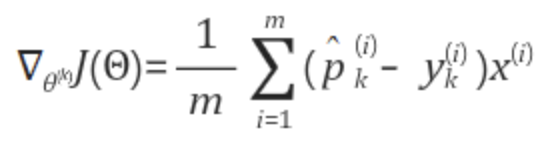

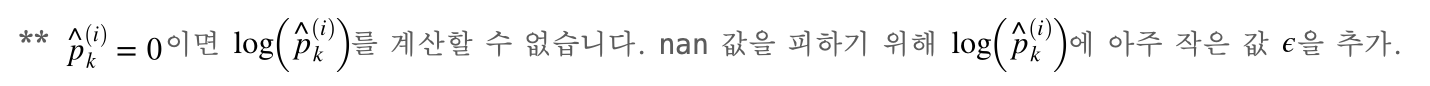

In [14]:
eta = 0.01 #학습률
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations): #0~5000
    logits = X_train.dot(Theta) #Theta행렬*X_train행렬
    Y_proba = softmax(logits) #소프트맥스 함수
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1)) #크로스 엔트로피 함수, epsilon 추가
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot #클래스 k에 속할 확률과 실제 간 차이
    gradients = 1/m * X_train.T.dot(error) #클래스 k에 대한 크로스 엔트로피의 그래디언트 벡터
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.44824244188957774
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390374


Theta가 for문을 돌면서 점진적으로 하강. 전체 set 사용하므로 배치 경사 하강법임.

In [15]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

In [16]:
#검증 세트에 대한 예측과 정확도 확인
#validation(검증 세트) 사용
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

In [17]:
#연습을 위해 규제 추가
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:])) #np.square()는 배열 원소들을 제곱시킴.
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.503640075014894
1500 0.4946891059460322
2000 0.4912968418075477
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


In [18]:
#검증 세트로 확인
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

In [19]:
#조기 종료 추가
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    #검증 세트와 같이 계산
    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "조기 종료!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580261
2000 0.5331959249285544
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327977 조기 종료!


In [20]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

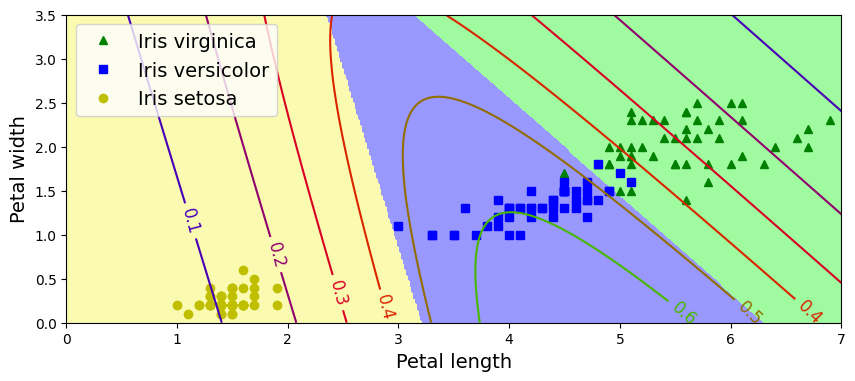

In [21]:
#전체 데이터셋에 대한 모델의 예측을 그래프로 그려보기
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [22]:
#테스트 세트에 대한 모델의 최종 정확도 측정
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

최종 모델의 성능이 조금 떨어짐. 이는 데이터셋이 작기 때문일 것임.